## Zadanie domowe: BBHE i DSIHE

W klasycznym wyrównywaniu histogramu HE  po wykonaniu operacji jasność obrazu ulega zmianie.
Dało się to zaobserwować podczas przeprowadzonych eksperymentów.
Jeśli nie to należy uruchomić skrypt z sekcji A i zwrócić na to uwagę.
Średnia jasność dąży do środkowego poziomu szarości.
Jest to wada i dlatego klasyczne HE ma ograniczone zastosowanie.

Powstało sporo metod, które eliminują to niekorzystne zjawisko.
Najprostsze z nich polegają na dekompozycji obrazu wejściowego na dwa podobrazy (wg. pewnego kryterium).
Następnie operacja HE wykonywana jest dla tych podobrazów.

Dwie znane z literatury metody to:
- Bi-Histogram Equalization
- DSIHE - Dualistic Sub-Image Histogram Equalization

W metodzie BBHE za kryterium podziału przyjmuje się średnią jasność w obrazie.
W DSIHE obraz dzieli się na dwa podobrazy o takiej samej liczbie pikseli (jaśniejszych i ciemniejszych).

W ramach zadania należy zaimplementować wybraną metodę: BBHE lub DSIHE (ew. obie).

1. Wczytaj obraz *jet.bmp* i wylicz jego histogram.
2. W kolejnym kroku należy wyznaczyć próg podziału obrazu na dwa podobrazy (*lm*).
3. Dla BBHE wyznacz średnią jasność obrazu. Dla DSIHE można wykorzystać histogram skumulowany.
Należy znaleźć poziom jasności który znajduje się "w połowie" histogramu skumulowanego.
W tym celu warto stworzyć tablicę, zawierającą moduł histogramu skumulowanego pomniejszonego o połowę liczby pikseli.
Następnie znaleźć minimum - `np.argmin`.
4. Dalej należy podzielić histogram oryginalnego obrazu na dwa histogramy *H1* i *H2*.
Dla każdego z nich wyliczyć histogram skumulowany ($C_1$ i $C_2$) i wykonać normalizację.
Normalizacja polega na podzieleniu każdego histogramu przez jego największy element.
5. Na podstawie histogramów skumulowanych należy stworzyć przekształcenie LUT.
Należy tak przeskalować $C_1$ i $C_2$, aby uzyskać jednorodne przekształcenie.
Tablicę $C_1$ wystarczy pomnożyć przez próg podziału.
Tablicę $C_2$ należy przeskalować do przedziału: $<lm+1; 255>$, gdzie $lm$ jest progiem podziału.<br>
$C_{1n} = (lm)*C1;$<br>
$C_{2n} = lm+1 + (255-lm-1)*C2;$<br>
Następnie dwie części tablicy przekodowań należy połączyć.
6. Ostatecznie należy wykonać operację LUT i wyświetlić wynik wyrównywania histogramu.
Porównaj wynik operacji BBHE lub DSIHE z klasycznym HE.

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/03_Histogram/'
fileName = 'images/jet.bmp'
if not os.path.exists(fileName) :
    r = requests.get(url + fileName, allow_redirects=True)
    open(fileName, 'wb').write(r.content)

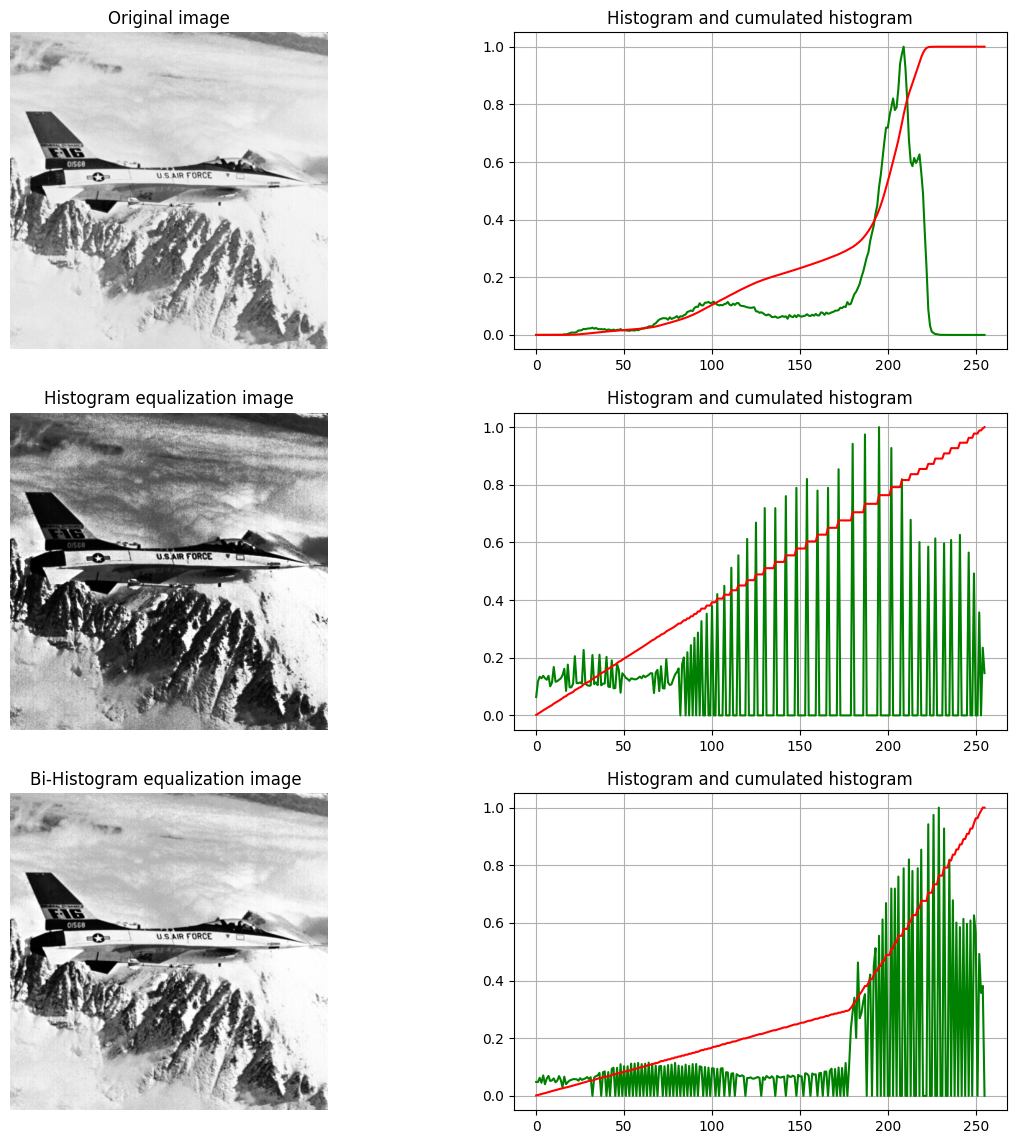

In [2]:
def normalized_hist(histogram):
    return histogram/np.max(histogram)

jet_image =  cv2.imread(fileName, cv2.IMREAD_GRAYSCALE)
jet_image_hist = cv2.calcHist([jet_image], [0], None, [256], [0,256])
jet_image_cum_hist = jet_image_hist.cumsum()

lm = round(np.mean(jet_image))

H1, H2 = jet_image_hist[:lm+1], jet_image_hist[lm+1:]

C1 = H1.cumsum()
C2 = H2.cumsum()

C1_normalized = normalized_hist(C1)
C2_normalized = normalized_hist(C2)

C1_lut = np.uint8([lm * C1_normalized])
C2_lut = np.uint8([lm + 1 + (255 - lm - 1) * C2_normalized])

lut_table = np.zeros(256, dtype=np.uint8)
lut_table[:lm+1] = C1_lut 
lut_table[lm+1:] = C2_lut

bbhe_image = cv2.LUT(jet_image, lut_table)
bbhe_image_hist = cv2.calcHist([bbhe_image], [0], None, [256], [0, 256])
bbhe_image_cum_hist = bbhe_image_hist.cumsum()

f, ax = plt.subplots(3, 2, figsize =(14, 14))

he_image = cv2.equalizeHist(jet_image)
he_hist = cv2.calcHist([he_image], [0], None, [256], [0, 256])
he_cum_hist = he_hist.cumsum()

figures = [
    ['Original image', jet_image, jet_image_hist, jet_image_cum_hist],
    ['Histogram equalization image',he_image, he_hist, he_cum_hist],
    ['Bi-Histogram equalization image ', bbhe_image, bbhe_image_hist, bbhe_image_cum_hist]
]




for idx, fig in enumerate(figures):
    ax[idx,0].imshow(fig[1], cmap='gray')
    ax[idx,0].axis('off')
    ax[idx,0].set_title(fig[0])
    
    ax[idx,1].plot(normalized_hist(fig[2]), c ='green')
    ax[idx,1].plot(normalized_hist(fig[3]), c ='red')
    ax[idx,1].grid()
    ax[idx,1].set_title(f'Histogram and cumulated histogram')
    
plt.show()



